In [2]:
import json
import os
from copy import deepcopy
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import torch
import torch.nn as nn

2025-01-12 14:37:25.548273: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-12 14:37:25.555860: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-12 14:37:25.564344: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-12 14:37:25.566877: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-12 14:37:25.573437: I tensorflow/core/platform/cpu_feature_guar

In [3]:
%load_ext autoreload
%autoreload 2

In [40]:
infile = '/home/yuan/results/epitope/epi_top_features.txt'
df = pd.read_csv(infile, sep='\t', header=0, index_col=None)
# df = df.iloc[:8_000_000,:]
# shuffle rows
df = df.sample(frac=1)
df.head()

,seq,label,mean_hydro_ph7,mean_hydro,mean_polar,mean_polar_stab,mean_VDWV,median_hydro_ph7,median_hydro,median_polar,...,has_C,has_I,has_L,has_K,has_F,has_P,has_S,has_T,has_Y,has_V
518236,YFCFSSDCIDGKDCK,1,19.200000,1.013333,8.486667,0.155000,3.374667,0.0,1.07,9.0,...,1,1,0,1,1,0,1,0,1,0
891857,KDGQWVSDA,0,7.333333,0.752222,9.488889,0.140667,3.106667,-5.0,0.46,9.2,...,0,0,0,1,0,0,1,0,0,1
1068433,TEITNKSAL,0,19.555556,0.687778,8.866667,0.133333,3.033333,13.0,0.47,8.6,...,0,1,1,1,0,0,1,1,0,0
1879830,SHGSPSSHGP,0,-9.600000,0.546000,9.160000,0.097000,2.116000,-5.0,0.07,9.2,...,0,0,0,0,0,1,1,0,0,0
2519626,TAWQSVGHM,1,32.666667,0.726667,8.088889,0.155111,3.257778,13.0,0.61,8.6,...,0,0,0,0,0,0,1,1,0,1


In [41]:
X = np.array(df.iloc[:,2:], dtype=np.float16)
y = np.array(df.iloc[:,1], dtype=np.float16)
print(X.shape, X.dtype, y.shape, y.dtype)

(3458238, 48) float16 (3458238,) float16


## ANN

In [6]:
model_ann = tf.keras.models.load_model('../models/epitopes_ann.keras')

In [103]:
# normalization X
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
norm_X = scaler.fit_transform(X)

# predict
pred_ann = model_ann.predict(norm_X)

108070/108070 ━━━━━━━━━━━━━━━━━━━━ 40s 366us/step


In [104]:
df['ann'] = list(pred_ann.flatten())
df.head()

,seq,label,mean_hydro_ph7,mean_hydro,mean_polar,mean_polar_stab,mean_VDWV,median_hydro_ph7,median_hydro,median_polar,...,has_I,has_L,has_K,has_F,has_P,has_S,has_T,has_Y,has_V,ann
518236,YFCFSSDCIDGKDCK,1,19.200000,1.013333,8.486667,0.155000,3.374667,0.0,1.07,9.0,...,1,0,1,1,0,1,0,1,0,0.507850
891857,KDGQWVSDA,0,7.333333,0.752222,9.488889,0.140667,3.106667,-5.0,0.46,9.2,...,0,0,1,0,0,1,0,0,1,0.316498
1068433,TEITNKSAL,0,19.555556,0.687778,8.866667,0.133333,3.033333,13.0,0.47,8.6,...,1,1,1,0,0,1,1,0,0,0.496633
1879830,SHGSPSSHGP,0,-9.600000,0.546000,9.160000,0.097000,2.116000,-5.0,0.07,9.2,...,0,0,0,0,1,1,0,0,0,0.257701
2519626,TAWQSVGHM,1,32.666667,0.726667,8.088889,0.155111,3.257778,13.0,0.61,8.6,...,0,0,0,0,0,1,1,0,1,0.433804


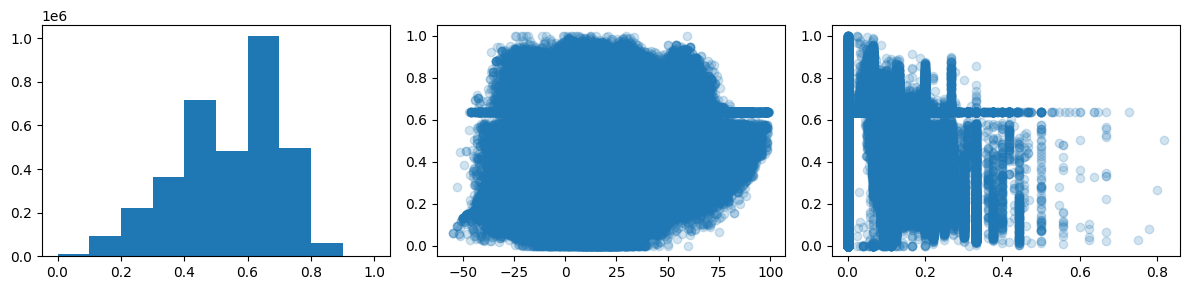

In [105]:
fig, ax = plt.subplots(1,3, figsize=(12,3), layout='tight')
i=0
ax[i].hist(pred_ann)
i=1
ax[i].scatter(df['mean_hydro_ph7'], df['ann'], alpha=.2)
i=2
ax[i].scatter(df['freq_C'], df['ann'], alpha=.2)

In [81]:
tp = df[df['label']==1]
print('true positive:', tp.shape)
tp_hprob = tp[tp['ann']>0.9]
tp_lprob = tp[tp['ann']<0.1]
print(f"true positive: low_prob={tp_lprob.shape}, high_prob={tp_hprob.shape}")

tn = df[df['label']==0]
print('true negative:', tn.shape)
tn_hprob = tn[tn['ann']>0.9]
tn_lprob = tn[tn['ann']<0.1]
print(f"true negative: low_prob={tn_lprob.shape}, high_prob={tn_hprob.shape}")

true positive: (1865242, 51)
true positive: low_prob=(6410, 51), high_prob=(1359, 51)
true negative: (1592996, 51)
true negative: low_prob=(5416, 51), high_prob=(1097, 51)


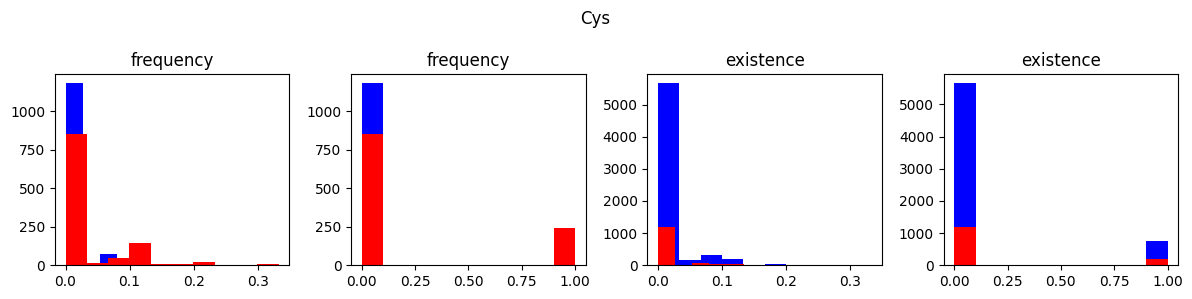

In [91]:
# epitope: lower cys
fig, ax = plt.subplots(1, 4, figsize=(12,3), layout='tight')
fig.suptitle('Cys')
i=0
feature = 'freq_C'
ax[i].hist(tp_hprob[feature], color='blue')
ax[i].hist(tn_hprob[feature], color='red')
ax[i].set_title('frequency')
i=1
feature = 'has_C'
ax[i].hist(tp_hprob[feature], color='blue')
ax[i].hist(tn_hprob[feature], color='red')
ax[i].set_title('frequency')

i=2
feature = 'freq_C'
ax[i].hist(tp_lprob[feature], color='blue')
ax[i].hist(tp_hprob[feature], color='red')
ax[i].set_title('existence')

i=3
feature = 'has_C'
ax[i].hist(tp_lprob[feature], color='blue')
ax[i].hist(tp_hprob[feature], color='red')
ax[i].set_title('existence')

plt.show()

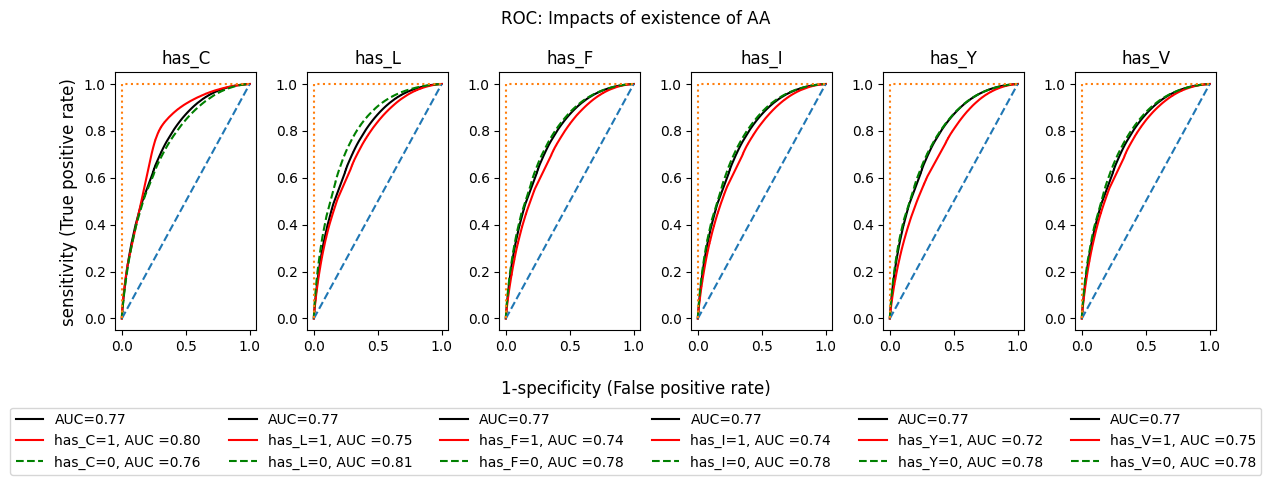

In [177]:
# ROC curve only for binary classfication
from sklearn.metrics import roc_curve, auc

# FPR, false positive rate, 1- specificity, typ I error
# TPR, true positive rate, sensitivity, power
fpr, tpr, thresholds = roc_curve(df['label'], df['ann'])
roc_auc = auc(fpr, tpr)
features = ['has_C','has_L', 'has_F', 'has_I','has_Y', 'has_V']

# 
fig, ax = plt.subplots(1,len(features), figsize=(12,4), layout='tight')
fig.supxlabel('1-specificity (False positive rate)')
fig.supylabel('sensitivity (True positive rate)')
fig.suptitle('ROC: Impacts of existence of AA')

# ==1 has_C, 
# ==0, has_L,has_F, has_Y, has_V
for i, feature in enumerate(features):
    # 
    has = df[df[feature]==1]
    fpr1, tpr1, thresholds1 = roc_curve(has['label'], has['ann'])
    roc_auc1 = auc(fpr1, tpr1)
    nhas = df[df[feature]==0]
    fpr2, tpr2, thresholds2 = roc_curve(nhas['label'], nhas['ann'])
    roc_auc2 = auc(fpr2, tpr2)
    # 
    ax[i].plot(fpr, tpr, label=f'AUC={roc_auc:.2f}', color='black')
    ax[i].plot(fpr1, tpr1, label=f'{feature}=1, AUC ={roc_auc1:.2f}', color='red')
    ax[i].plot(fpr2, tpr2, label=f'{feature}=0, AUC ={roc_auc2:.2f}', color='green', linestyle='--')
    ax[i].plot([0,1], [0,1], '--')
    ax[i].plot([0,0,1], [0,1,1], ':')
    ax[i].set_title(feature)

fig.legend(bbox_to_anchor=(0.5, -0.2), loc='lower center', ncol=len(features))

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(12,3), layout='tight')
i=0
ax[i].hist(tp['ann'])
for feature in ['mean_hydro_ph7', 'freq_C', 'freq_V', 'freq_Y']:
    i += 1
    ax[i].scatter(extreme[feature], extreme['ann'], alpha=.1)
    ax[i].set_title(feature)